In [1]:
# Import dependencies 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import collections
import researchpy as rp
import scipy as sp
from sklearn.preprocessing import LabelEncoder
import re
import os
import matplotlib.pyplot as plt

## Database - RDS on AWS and postgreSQL engine

In [2]:
# For database
import sqlalchemy
from sqlalchemy import create_engine
import psycopg2

# Importing the database credentials from the db_params
import db_params as creds

In [3]:
# Setting up a connection to the postgres server
conn_string = "host="+ creds.DBHOST +" port="+ creds.DBPORT +" dbname="+ creds.DBNAME \
              + " user=" + creds.DBUSER +" password="+ creds.DBPASSWORD

# Connect to the AWS postgres database
conn = psycopg2.connect(conn_string)
print("Database Connected Successfully!")

Database Connected Successfully!


In [4]:
# Create a cursor object
cur = conn.cursor()
    
# Drop the diabetes_raw_data if exists before creating one
cur.execute("DROP TABLE IF EXISTS medicines_info");
cur.execute("DROP TABLE IF EXISTS admission_info");
cur.execute("DROP TABLE IF EXISTS diagnosis_info");
cur.execute("DROP TABLE IF EXISTS patient_info");
cur.execute("DROP TABLE IF EXISTS diabetes_clean_data");
cur.execute("DROP TABLE IF EXISTS diabetes_raw_data");
conn.commit()

In [5]:
# Create diabetes_raw_data table
cur = conn.cursor()
cur.execute('''CREATE TABLE diabetes_raw_data (
    encounter_id int NOT NULL,
    patient_nbr	int NOT NULL,
    race varchar(20),
    gender varchar(20) NOT NULL,
    age varchar(10) NOT NULL,
    weight varchar(10),
    admission_type_id int NOT NULL,
    discharge_disposition_id int NOT NULL,
    admission_source_id int NOT NULL,
    time_in_hospital int NOT NULL,
    payer_code varchar(10),
    medical_specialty varchar(40),
    num_lab_procedures  int NOT NULL,
    num_procedures  int NOT NULL,
    num_medications  int NOT NULL,
    number_outpatient  int NOT NULL,
    number_emergency  int NOT NULL,
    number_inpatient  int NOT NULL,
    diag_1  varchar(10),
    diag_2 varchar(10),
    diag_3 varchar(10),
    number_diagnoses  int NOT NULL,
    max_glu_serum  varchar(10),
    A1Cresult  varchar(10),
    metformin  varchar(10),
    repaglinide  varchar(10),
    nateglinide  varchar(10),
    chlorpropamide  varchar(10),
    glimepiride  varchar(10),
    acetohexamide  varchar(10),
    glipizide  varchar(10),
    glyburide  varchar(10),
    tolbutamide  varchar(10),
    pioglitazone  varchar(10),
    rosiglitazone  varchar(10),
    acarbose  varchar(10),
    miglitol  varchar(10),
    troglitazone  varchar(10),
    tolazamide  varchar(10),
    examide  varchar(10),
    citoglipton  varchar(10),
    insulin  varchar(10),
    "glyburide-metformin"  varchar(10),
    "glipizide-metformin"  varchar(10),
    "glimepiride-pioglitazone"  varchar(10),
    "metformin-rosiglitazone"  varchar(10),
    "metformin-pioglitazone"  varchar(10),
    change  varchar(10),
    diabetesMed  varchar(10),
    readmitted  varchar(10),
    PRIMARY KEY (encounter_id),
    UNIQUE (encounter_id));''')
print("Table 'diabetes_raw_data' successfully created")
conn.commit()

Table 'diabetes_raw_data' successfully created


In [6]:
# Copy the contents from the diabetic_data_initial.csv and write it to 'diabetes_raw_data' table
sql = "COPY diabetes_raw_data FROM STDIN DELIMITER ',' CSV HEADER"
cur.copy_expert(sql, open(creds.CSV_FILE_PATH, "r"))

In [7]:
# Create the connection to the PostgreSQL database
db_string = f"postgres://{creds.DBUSER}:{creds.DBPASSWORD}@{creds.DBHOST}:{creds.DBPORT}/{creds.DBNAME}"
engine = create_engine(db_string)
conn.commit()

In [8]:
# Read the raw data from the postgres into dataframe
df = pd.read_sql_table("diabetes_raw_data", engine)
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesmed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


# Datacleaning

In [9]:
pd.set_option('display.max_columns', None)
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,a1cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesmed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [10]:
# Show columns with missing greater than 20%
for column in df:
    if df[df[column]=='?'].shape[0]/df.shape[0]*100 > 20:
        print(column,":",str(round(df[df[column]=='?'].shape[0]/df.shape[0]*100)) + "%")              

weight : 97%
payer_code : 40%
medical_specialty : 49%


In [11]:
# variables weight and payer_code were excluded due to quantity of missing data
# medical specialty was recoded to add "missing" for the missing values.

In [12]:
# drop weight and payer_code columns 
df_copy = df.copy()
df_copy.drop(columns=['weight', 'payer_code'], axis=1, inplace=True)

In [13]:
# In order to keep observations independent, only one the first encounter is included
# Dedupe based on first encounter
df_deduped = df_copy.drop_duplicates(subset=['patient_nbr'], keep='first')

In [14]:
# Remove encounters that resulted in either discharge to 
# a hospice or patient death to avoid biasing analysis 
discharge_disposition_excluded=[11, 13, 14, 19, 20, 23]

df_cleaned = df_deduped[~df_deduped.discharge_disposition_id.isin(discharge_disposition_excluded)]

In [15]:
df_cleaned['gender'].value_counts()

Female             37084
Male               32626
Unknown/Invalid        3
Name: gender, dtype: int64

In [16]:
df_cleaned.drop(df_cleaned[(df_cleaned.loc[:,'gender'] == "Unknown/Invalid")].index, inplace = True)
df_cleaned['gender'].value_counts()

/Users/anusuyapoonja/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Female    37084
Male      32626
Name: gender, dtype: int64

In [17]:
# recode readmitted to be binary 
def recode_readmit(x):
    if x == '<30':
        return 1
    else:
        return 0

df_cleaned['readmitted_recoded'] = df_cleaned['readmitted'].apply(recode_readmit)
# df_cleaned['readmitted_recoded'] = df_cleaned[df_cleaned.loc[:,'readmitted']].apply(recode_readmit)
# df_cleaned['readmitted_recoded'] = df_cleaned.loc[:,['readmitted']].replace({'>30': 'NO'})

/Users/anusuyapoonja/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
# recode medical_specialty to add missing 
df_cleaned['medical_specialty_recoded'] = df_cleaned.loc[:,['medical_specialty']].replace("?",'missing', inplace=False)

/Users/anusuyapoonja/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# readmitted recoded is imbalanced with 91% of cases 
# not having a 30 day readmission
print(collections.Counter(df_cleaned['readmitted_recoded']))

Counter({0: 63441, 1: 6269})


In [20]:
df_cleaned['medical_specialty_recoded'].value_counts()

missing                   33507
InternalMedicine          10582
Family/GeneralPractice     4955
Emergency/Trauma           4390
Cardiology                 4198
                          ...  
Dermatology                   1
Psychiatry-Addictive          1
Speech                        1
Proctology                    1
Resident                      1
Name: medical_specialty_recoded, Length: 71, dtype: int64

In [21]:
df_cleaned['medical_specialty_recoded'] = df_cleaned.loc[:,['medical_specialty_recoded']].replace({'Family/GeneralPractice': 'InternalMedicine'})

def values_to_other(col_name, value_unchanged):
    v=[]
    for value in col_name:
        if (value != value_unchanged):
            v.append("Other")
        else:
            v.append(value)
    return v
    

df_cleaned['medical_specialty_recoded'] = values_to_other(df_cleaned['medical_specialty_recoded'].values,"InternalMedicine")    



/Users/anusuyapoonja/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/anusuyapoonja/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [22]:
df_cleaned['medical_specialty_recoded'].value_counts()

Other               54173
InternalMedicine    15537
Name: medical_specialty_recoded, dtype: int64

In [23]:
# readmitted recoded is imbalanced with 91% of cases 
# not having a 30 day readmission
print(collections.Counter(df_cleaned['readmitted_recoded']))

Counter({0: 63441, 1: 6269})


In [24]:
# function to clean 'age' column
def parse_age_range(age_col):
    c=[]
    for values in age_col:
        s = re.sub('[[)]','', values)
        c.append(s)
    return c

# replace 'age' values with cleaned values
df_cleaned['age'] = parse_age_range(df_cleaned['age'].values)

/Users/anusuyapoonja/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [25]:
df_cleaned = df_cleaned.drop(columns=['readmitted', 'medical_specialty'])

In [26]:
df_cleaned.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted_recoded',
       'medical_specialty_recoded'],
      dtype='object')

In [27]:
df_cleaned.dtypes

encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                object
a1cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                   

# Database - Export cleaned data to new table

In [31]:
# DB code to export cleaned dataset to DB
# Create a cursor
cur = conn.cursor()
# Drop the diabetes_cleaned_data if exists before creating one
cur.execute("DROP TABLE IF EXISTS diabetes_clean_data");
conn.commit()

In [32]:
# Write the cleaned data fro diabetes_clean_data_df into postgres diabetes_clean_data table 
# Note : This step will take some time.. breathe....
df_cleaned.to_sql(name='diabetes_clean_data', con=engine, if_exists='replace', index=False, method='multi',
            dtype={'encounter_id': sqlalchemy.types.INTEGER(),
                   'patient_nbr' : sqlalchemy.types.INTEGER(),
                   'race' : sqlalchemy.types.VARCHAR(length=20),
                   'gender' : sqlalchemy.types.VARCHAR(length=20),
                   'age' : sqlalchemy.types.VARCHAR(length=10),
    'admission_type_id' : sqlalchemy.types.INTEGER(),
    'discharge_disposition_id' : sqlalchemy.types.INTEGER(),
    'admission_source_id' : sqlalchemy.types.INTEGER(),
    'time_in_hospital' : sqlalchemy.types.INTEGER(),
    'num_lab_procedures' :  sqlalchemy.types.INTEGER(),
    'num_procedures' :  sqlalchemy.types.INTEGER(),
    'num_medications' :  sqlalchemy.types.INTEGER(),
    'number_outpatient' :  sqlalchemy.types.INTEGER(),
    'number_emergency' :  sqlalchemy.types.INTEGER(),
    'number_inpatient' :  sqlalchemy.types.INTEGER(),
    'diag_1' :  sqlalchemy.types.VARCHAR(length=10),
    'diag_2' : sqlalchemy.types.VARCHAR(length=10),
    'diag_3' : sqlalchemy.types.VARCHAR(length=10),
    'metformin' :  sqlalchemy.types.VARCHAR(length=10),
    'repaglinide' :  sqlalchemy.types.VARCHAR(length=10),
    'nateglinide' :  sqlalchemy.types.VARCHAR(length=10),
    'chlorpropamide' :  sqlalchemy.types.VARCHAR(length=10),
    'glimepiride' :  sqlalchemy.types.VARCHAR(length=10),
    'acetohexamide' :  sqlalchemy.types.VARCHAR(length=10),
    'glipizide' :  sqlalchemy.types.VARCHAR(length=10),
    'glyburide' :  sqlalchemy.types.VARCHAR(length=10),
    'tolbutamide' :  sqlalchemy.types.VARCHAR(length=10),
    'pioglitazone' :  sqlalchemy.types.VARCHAR(length=10),
    'rosiglitazone' :  sqlalchemy.types.VARCHAR(length=10),
    'acarbose' :  sqlalchemy.types.VARCHAR(length=10),
    'miglitol' :  sqlalchemy.types.VARCHAR(length=10),
    'troglitazone' :  sqlalchemy.types.VARCHAR(length=10),
    'tolazamide' :  sqlalchemy.types.VARCHAR(length=10),
    'examide' :  sqlalchemy.types.VARCHAR(length=10),
    'citoglipton' :  sqlalchemy.types.VARCHAR(length=10),
    'insulin' :  sqlalchemy.types.VARCHAR(length=10),
    'glyburide-metformin' :  sqlalchemy.types.VARCHAR(length=10),
    'glipizide-metformin' :  sqlalchemy.types.VARCHAR(length=10),
    'glimepiride-pioglitazone' : sqlalchemy.types.VARCHAR(length=10),
    'metformin-rosiglitazone' :  sqlalchemy.types.VARCHAR(length=10),
    'metformin-pioglitazone' :  sqlalchemy.types.VARCHAR(length=10),
    'change' : sqlalchemy.types.VARCHAR(length=10),
    'diabetesMed' :  sqlalchemy.types.VARCHAR(length=10),
    'readmitted_recoded' :  sqlalchemy.types.VARCHAR(length=10),
    'medical_specialty_recoded' : sqlalchemy.types.VARCHAR(length=40)})
print("Table 'diabetes_clean_data' successfully created")
# Note : This step will take some time.. like 5-10 mins.. breatheeee... one more time....

Table 'diabetes_clean_data' successfully created


# Summary Statistics: EDA

In [33]:
# Read the raw data from the postgres into dataframe
df_cleaned = pd.read_sql_table("diabetes_clean_data", engine)
df_cleaned

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,a1cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesmed,readmitted_recoded,medical_specialty_recoded
0,2278392,8222157,Caucasian,Female,0-10,6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,Other
1,149190,55629189,Caucasian,Female,10-20,1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
2,64410,86047875,AfricanAmerican,Female,20-30,1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,Other
3,500364,82442376,Caucasian,Male,30-40,1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
4,16680,42519267,Caucasian,Male,40-50,1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69705,443842016,183087545,Caucasian,Female,70-80,1,1,7,9,50,2,33,0,0,0,574,574,250.02,9,None,>7,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,Other
69706,443842022,188574944,Other,Female,40-50,1,1,7,14,73,6,26,0,1,0,592,599,518,9,None,>8,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
69707,443842070,140199494,Other,Female,60-70,1,1,7,2,46,6,17,1,1,1,996,585,403,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0,Other
69708,443842340,120975314,Caucasian,Female,80-90,1,1,7,5,76,1,22,0,1,0,292,8,304,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other


In [34]:
# 69,710 records in the dataset 
display(df_cleaned.describe())


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,6.971000e+04,6.971000e+04,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000,69710.000000
mean,1.565601e+08,5.494146e+07,2.107761,3.339334,5.638244,4.261842,42.859489,1.424258,15.634543,0.279501,0.103816,0.176359,7.220944
std,1.004215e+08,3.949663e+07,1.509596,5.049503,4.166790,2.925141,19.904059,1.756553,8.254529,1.063143,0.511998,0.602274,2.001574
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.106699e+07,2.333357e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.437268e+08,4.800196e+07,1.000000,1.000000,7.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,2.153859e+08,8.751431e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


In [35]:
# 53.25% of admissions came from Trauma Center followed by ED
display(rp.summary_cat(df_cleaned[['admission_source_id']]))


,Variable,Outcome,Count,Percent
0,admission_source_id,7,37122,53.25
1,,1,21653,31.06
2,,17,4808,6.90
3,,4,2524,3.62
4,,6,1783,2.56
5,,2,902,1.29
6,,5,506,0.73
7,,20,153,0.22
8,,3,136,0.20
9,,9,95,0.14


In [36]:
# ~75% of cases were caucasian followed by 18% for African American 
display(rp.summary_cat(df_cleaned[['race']]))


,Variable,Outcome,Count,Percent
0,race,Caucasian,52117,74.76
1,,AfricanAmerican,12550,18.00
2,,?,1912,2.74
3,,Hispanic,1499,2.15
4,,Other,1144,1.64
5,,Asian,488,0.70


,Variable,Outcome,Count,Percent
0,gender,Female,37084,53.2
1,,Male,32626,46.8


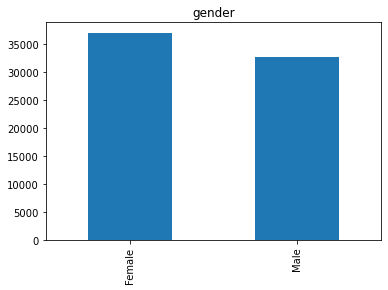

In [37]:
# 53% cases were female, 47% male 
display(rp.summary_cat(df_cleaned[['gender']]))
df_cleaned.gender.value_counts().plot(kind='bar', title='gender')
plt.show()


,Variable,Outcome,Count,Percent
0,age,70-80,17673,25.35
1,,60-70,15621,22.41
2,,50-60,12320,17.67
3,,80-90,11046,15.85
4,,40-50,6809,9.77
5,,30-40,2692,3.86
6,,90-100,1743,2.50
7,,20-30,1119,1.61
8,,10-20,534,0.77
9,,0-10,153,0.22


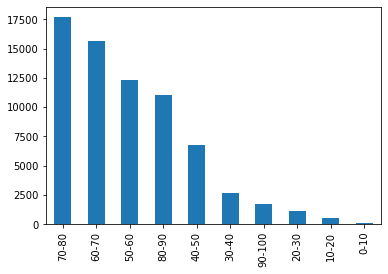

In [38]:
#~81% of cases above age 50
df_cleaned.age.value_counts().plot(kind='bar')
display(rp.summary_cat(df_cleaned[['age']]))


In [39]:
# Average time in hospital 4.26 days 
df_cleaned.agg(
    {
    'num_medications':["min", "max", "mean","median", "skew"], 
    'num_lab_procedures':["min", "max", "mean","median", "skew"],
        'time_in_hospital':["min", "max", "mean","median", "skew"], 
        'num_lab_procedures':["min", "max", "mean","median", "skew"], 
                  'num_procedures':["min", "max", "mean","median", "skew"], 
        'num_medications':["min", "max", "mean","median", "skew"], 
                  'number_outpatient':["min", "max", "mean","median", "skew"], 
        'number_emergency':["min", "max", "mean","median", "skew"], 
        'number_inpatient':["min", "max", "mean","median", "skew"], 
        'number_diagnoses':["min", "max", "mean","median", "skew"]
    }
)

,num_medications,num_lab_procedures,time_in_hospital,num_procedures,number_outpatient,number_emergency,number_inpatient,number_diagnoses
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,81.000000,132.000000,14.000000,6.000000,42.000000,42.000000,12.000000,16.000000
mean,15.634543,42.859489,4.261842,1.424258,0.279501,0.103816,0.176359,7.220944
median,14.000000,44.000000,3.000000,1.000000,0.000000,0.000000,0.000000,8.000000
skew,1.424810,-0.218656,1.183085,1.228562,9.690407,21.279108,5.587093,-0.723398


In [40]:
# average time in hospital slightly longer (4.78 days) for those readmitted less than 30 days vs those not readmitted (4.21 days)
df_cleaned.loc[:,['time_in_hospital', 'num_lab_procedures', 
                  'num_procedures', 'num_medications', 
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']].groupby(df_cleaned['readmitted_recoded']).mean()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
readmitted_recoded,,,,,,,,
0,4.209234,42.656027,1.424221,15.53798,0.276682,0.099258,0.157312,7.192194
1,4.794226,44.918488,1.424629,16.61174,0.308024,0.149944,0.369118,7.511884


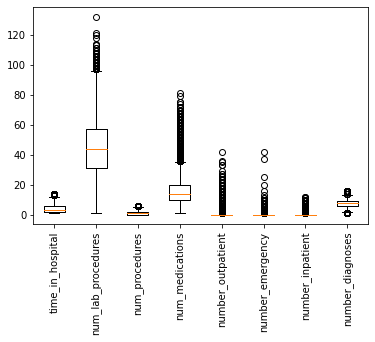

In [41]:
fig, ax = plt.subplots()

sum_cols = ['time_in_hospital', 'num_lab_procedures', 
                  'num_procedures', 'num_medications', 
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
ax.boxplot(df_cleaned[sum_cols].values)
plt.xticks([1, 2, 3,4,5,6,7,8], sum_cols, rotation='vertical')
plt.show()

In [42]:
df_cleaned.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,a1cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesmed,readmitted_recoded,medical_specialty_recoded
0,2278392,8222157,Caucasian,Female,0-10,6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,Other
1,149190,55629189,Caucasian,Female,10-20,1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
2,64410,86047875,AfricanAmerican,Female,20-30,1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,Other
3,500364,82442376,Caucasian,Male,30-40,1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Other
4,16680,42519267,Caucasian,Male,40-50,1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,Other


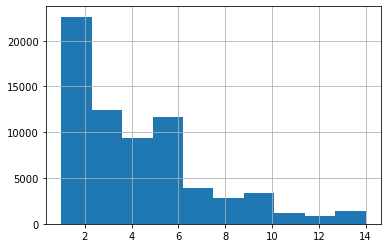

In [43]:
df_cleaned.time_in_hospital.hist()

# Data Pre-Processing

In [44]:
encoded_df = df_cleaned.copy()

In [45]:
df_cleaned.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted_recoded',
       'medical_specialty_recoded'],
      dtype='object')

In [46]:
# Show missing in dataset 
for column in df_cleaned.columns:
    missing_count = df_cleaned[column].isnull().sum()
    if missing_count>0:
        print(column,":",df_cleaned)

In [47]:
df_cleaned.drop(df_cleaned[df_cleaned['num_lab_procedures'] > 95].index, inplace = True) 
df_cleaned.drop(df_cleaned[df_cleaned['num_medications'] > 32].index, inplace = True) 
df_cleaned.drop(df_cleaned[df_cleaned['number_diagnoses'] > 13].index, inplace = True)
df_cleaned.drop(df_cleaned[df_cleaned['num_procedures'] > 5].index, inplace = True)

In [48]:
# Create a list of columns to encode for each variable if variable type is object
columns_to_encode = [column for column in df_cleaned.columns if df_cleaned[column].dtypes == 'O']

In [49]:
print(columns_to_encode)

['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted_recoded', 'medical_specialty_recoded']


In [50]:
# exclude diag 1, 2, and 3 from recode list 
for i in range(3):
    to_remove = 'diag_' + str(i+1)
    columns_to_encode.remove(to_remove)
print(columns_to_encode)
print("\n", len(columns_to_encode), "columns")

['race', 'gender', 'age', 'max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted_recoded', 'medical_specialty_recoded']

 32 columns


In [51]:
encoded_df = df_cleaned.copy()

In [52]:
# function to apply label encoding
def apply_encoder(cols):
    le = LabelEncoder()
    for c in cols:
        new_column_name = c + "_le"
        le.fit(df_cleaned[c])
        encoded_df[new_column_name] = le.transform(encoded_df[c])
        print(c, ":", le.classes_)

In [53]:
# Apply Encoding
apply_encoder(columns_to_encode)

race : ['?' 'AfricanAmerican' 'Asian' 'Caucasian' 'Hispanic' 'Other']
gender : ['Female' 'Male']
age : ['0-10' '10-20' '20-30' '30-40' '40-50' '50-60' '60-70' '70-80' '80-90'
 '90-100']
max_glu_serum : ['>200' '>300' 'None' 'Norm']
a1cresult : ['>7' '>8' 'None' 'Norm']
metformin : ['Down' 'No' 'Steady' 'Up']
repaglinide : ['Down' 'No' 'Steady' 'Up']
nateglinide : ['Down' 'No' 'Steady' 'Up']
chlorpropamide : ['Down' 'No' 'Steady' 'Up']
glimepiride : ['Down' 'No' 'Steady' 'Up']
acetohexamide : ['No']
glipizide : ['Down' 'No' 'Steady' 'Up']
glyburide : ['Down' 'No' 'Steady' 'Up']
tolbutamide : ['No' 'Steady']
pioglitazone : ['Down' 'No' 'Steady' 'Up']
rosiglitazone : ['Down' 'No' 'Steady' 'Up']
acarbose : ['No' 'Steady' 'Up']
miglitol : ['Down' 'No' 'Steady' 'Up']
troglitazone : ['No' 'Steady']
tolazamide : ['No' 'Steady']
examide : ['No']
citoglipton : ['No']
insulin : ['Down' 'No' 'Steady' 'Up']
glyburide-metformin : ['Down' 'No' 'Steady' 'Up']
glipizide-metformin : ['No' 'Steady']
glim

In [54]:
encoded_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted_recoded',
       'medical_specialty_recoded', 'race_le', 'gender_le', 'age_le',
       'max_glu_serum_le', 'a1cresult_le', 'metformin_le', 'repagl

In [55]:
cols_to_drop = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id','max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted_recoded',
       'medical_specialty_recoded', 'diag_1', 'diag_2', 'diag_3']
encoded_df = encoded_df.drop(columns=cols_to_drop)

# Machine Learning Model: LogisticRegression

In [56]:
encoded_df.head(5)

,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_le,gender_le,age_le,max_glu_serum_le,a1cresult_le,metformin_le,repaglinide_le,nateglinide_le,chlorpropamide_le,glimepiride_le,acetohexamide_le,glipizide_le,glyburide_le,tolbutamide_le,pioglitazone_le,rosiglitazone_le,acarbose_le,miglitol_le,troglitazone_le,tolazamide_le,examide_le,citoglipton_le,insulin_le,glyburide-metformin_le,glipizide-metformin_le,glimepiride-pioglitazone_le,metformin-rosiglitazone_le,metformin-pioglitazone_le,change_le,diabetesmed_le,readmitted_recoded_le,medical_specialty_recoded_le
0,25,1,1,41,0,1,0,0,0,1,3,0,0,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1
1,1,7,3,59,0,18,0,0,0,9,3,0,1,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,0,0,3,1,0,0,0,0,0,1,0,1
2,1,7,2,11,5,13,2,0,1,6,1,0,2,2,2,1,1,1,1,1,0,2,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1
3,1,7,2,44,1,16,0,0,0,7,3,1,3,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,0,0,3,1,0,0,0,0,0,1,0,1
4,1,7,1,51,0,8,0,0,0,5,3,1,4,2,2,1,1,1,1,1,0,2,1,0,1,1,0,1,0,0,0,0,2,1,0,0,0,0,0,1,0,1


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
y = encoded_df["readmitted_recoded_le"]
X = encoded_df.drop(columns=['readmitted_recoded_le'])
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y)

def list_feature_imp(X_train_input, y_train_input):
    x_values = []
    y_values = []
    # Create a random forest classifier.
    rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 
    # Fitting the model
    rf_model = rf_model.fit(X_train_input, y_train_input)
    # Calculate feature importance in the Random Forest model.
    importances = rf_model.feature_importances_
    feature_imp = sorted(zip(importances, X.columns), reverse=True)
    for features in feature_imp:
        print(f"{features}")
        x_values.append(features[0])
        y_values.append(features[1])
#     Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(10,15))
    ax.barh(y_values, x_values, align='center')
#     ax.text(0.15, y_values, x_values, fontsize=12)
    ax.invert_yaxis()

(0.15123287757303358, 'num_lab_procedures')
(0.1252165574797416, 'num_medications')
(0.08391100880381573, 'time_in_hospital')
(0.06852185983476597, 'age_le')
(0.058508216337291474, 'number_diagnoses')
(0.058332305797445555, 'num_procedures')
(0.05283173248111487, 'discharge_disposition_id')
(0.04221200134020092, 'admission_source_id')
(0.03717593003762314, 'insulin_le')
(0.03466731064094798, 'race_le')
(0.028959054758821677, 'gender_le')
(0.02757439253246107, 'a1cresult_le')
(0.027382867577095852, 'number_inpatient')
(0.026813938460125735, 'number_outpatient')
(0.019813529913014914, 'medical_specialty_recoded_le')
(0.01934282147720086, 'metformin_le')
(0.01928272148075157, 'glipizide_le')
(0.017827786151971205, 'change_le')
(0.01738077105830198, 'number_emergency')
(0.016751438248297303, 'glyburide_le')
(0.012289139148679828, 'pioglitazone_le')
(0.01125264326604706, 'rosiglitazone_le')
(0.010992373068007582, 'max_glu_serum_le')
(0.010986421610448376, 'glimepiride_le')
(0.01003043127830

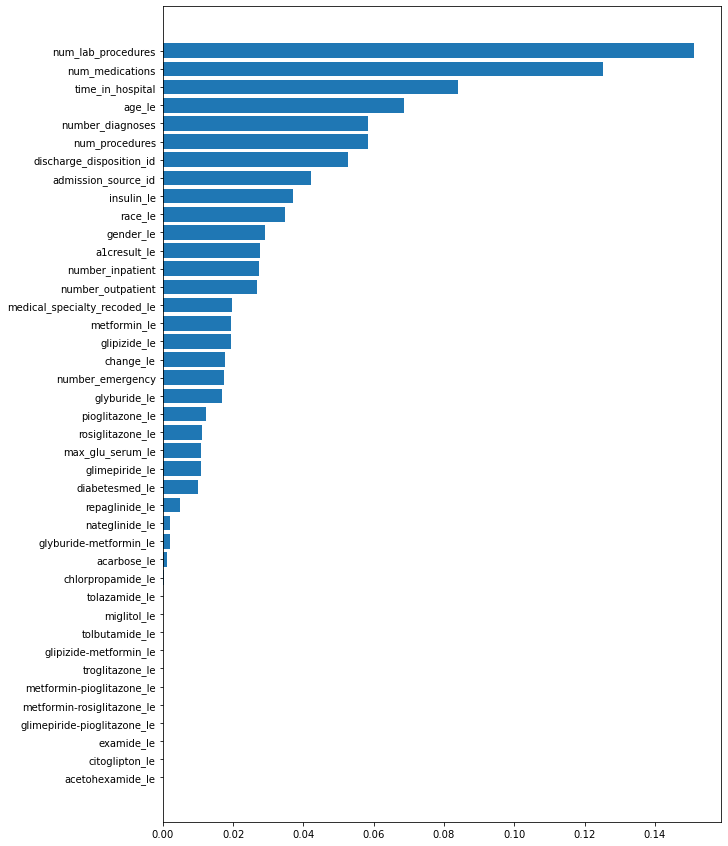

In [58]:
list_feature_imp(X_train, y_train)

In [59]:
X = X.drop(columns=['acetohexamide_le', 
                             'tolbutamide_le', 
                             'miglitol_le', 
                             'troglitazone_le',
                             'metformin-rosiglitazone_le', 
                             'metformin-pioglitazone_le', 
                             'glipizide-metformin_le', 
                             'glimepiride-pioglitazone_le', 
                             'examide_le', 
                             'citoglipton_le',
                             'glyburide-metformin_le',
                             'acarbose_le',
                             'chlorpropamide_le',
                             'tolazamide_le',
                            'number_emergency',
                            'number_outpatient',
                             'number_inpatient',
                            'nateglinide_le',
                            'repaglinide_le',
                            'diabetesmed_le',
                            'max_glu_serum_le'
                            ])

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
# from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from collections import Counter
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y)


# ros = RandomUnderSampler(random_state=1)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# Counter(y_resampled)

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_resampled)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_resampled)
X_test_scaled = X_scaler.transform(X_test)

In [61]:
from yellowbrick.classifier import ClassificationReport
import matplotlib.gridspec as gridspec
def apply_ml_model(X_train_input, y_train_input, X_test_input, y_test_input):
    models = ['LREG','RFC','Tree','Balanced RFC']
    scores = []
    # Specify the target classes
    classes = ["No re-admission","Re-admission in < 30 days"]
    for model in models:
        if model == 'LREG':
            model_select = LogisticRegression(solver='lbfgs', max_iter=500, random_state=78)
        elif model == 'RFC':
            model_select = RandomForestClassifier(n_estimators= 128, random_state=78)
        elif model == 'Tree':
            model_select = tree.DecisionTreeClassifier(random_state=78)
        elif model == 'Balanced RFC':
            model_select = BalancedRandomForestClassifier(n_estimators=128, random_state=78)
        model_select.fit(X_train_input, y_train_input)
        y_pred = model_select.predict(X_test_input)
        # Create a DataFrame from the confusion matrix.
        cm = confusion_matrix(y_test_input, y_pred)
        # Calculating the accuracy score.
        acc_score = balanced_accuracy_score(y_test, y_pred)
        scores.append(acc_score)
        print(f"Model: {model}")
        # Displaying results
        print("Confusion Matrix")
        cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
        print(cm_df)
        print(f"Accuracy Score : {acc_score}\n")
        print("Classification Report")
        print(classification_report_imbalanced(y_test_input, y_pred))
        visualizer = ClassificationReport(model_select, classes=classes, support=True)
        visualizer.fit(X_train_input, y_train_input)        # Fit the visualizer and the model
        visualizer.score(X_test_input, y_test_input)        # Evaluate the model on the test data
        visualizer.show()                       # Finalize and show the figure

Model: LREG
Confusion Matrix
          Predicted 0  Predicted 1
Actual 0         8271         6293
Actual 1          756          679
Accuracy Score : 0.5205389500338289

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.57      0.47      0.70      0.52      0.27     14564
          1       0.10      0.47      0.57      0.16      0.52      0.27      1435

avg / total       0.84      0.56      0.48      0.65      0.52      0.27     15999



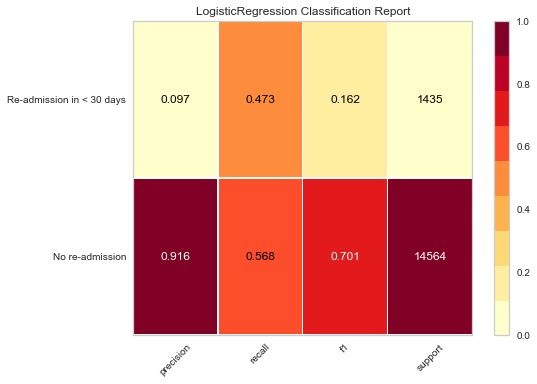

Model: RFC
Confusion Matrix
          Predicted 0  Predicted 1
Actual 0        13001         1563
Actual 1           81         1354
Accuracy Score : 0.9181172946131313

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.89      0.94      0.94      0.92      0.84     14564
          1       0.46      0.94      0.89      0.62      0.92      0.85      1435

avg / total       0.95      0.90      0.94      0.91      0.92      0.84     15999



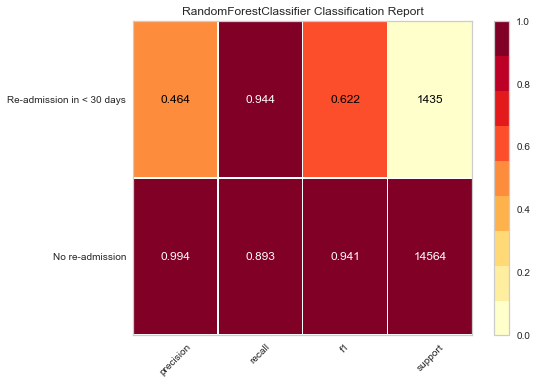

Model: Tree
Confusion Matrix
          Predicted 0  Predicted 1
Actual 0        12319         2245
Actual 1           66         1369
Accuracy Score : 0.8999298781684015

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.85      0.95      0.91      0.90      0.80     14564
          1       0.38      0.95      0.85      0.54      0.90      0.82      1435

avg / total       0.94      0.86      0.94      0.88      0.90      0.80     15999



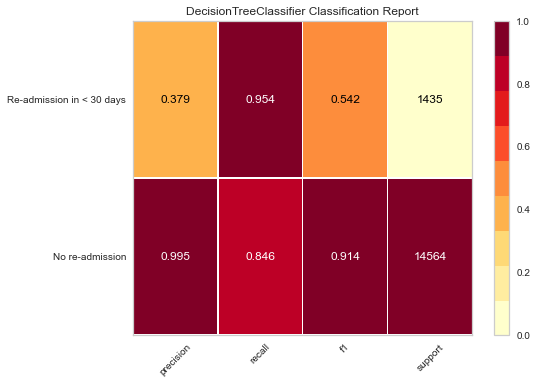

Model: Balanced RFC
Confusion Matrix
          Predicted 0  Predicted 1
Actual 0        13503         1061
Actual 1          485          950
Accuracy Score : 0.7945850203882037

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.93      0.66      0.95      0.78      0.63     14564
          1       0.47      0.66      0.93      0.55      0.78      0.60      1435

avg / total       0.92      0.90      0.69      0.91      0.78      0.63     15999



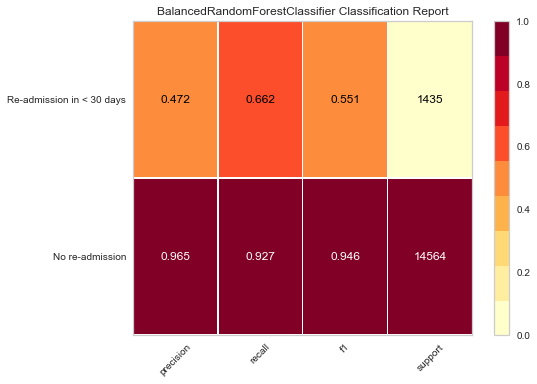

In [62]:
apply_ml_model(X_train_scaled, y_resampled, X_test_scaled, y_test)

In [63]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec